# Sigrid Juselius 2022

# LEMON Dataset Behavioural clustering

Link to dataset description website:
http://fcon_1000.projects.nitrc.org/indi/retro/MPI_LEMON.html

Link to publication describing the dataset:
https://www.nature.com/articles/sdata2018308

In [3]:
'''

If SAVE_FILES set to True, the script will generate processed data files and plots.
False by default.

If VERBOSE set to True, the script will output additional information.
False by default.
'''
SAVE_FILES = False
VERBOSE = False

## Import packages and set data folders 

In [4]:
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
import sys
import pickle as pkl

In [5]:
DATASET_PATH = "/Users/artemii/obrain_lab/projects/obesity-types/datasets/mind-brain-body/Behavioural_Data_MPILMBB_LEMON/"
SCRIPTS_PATH = "/Users/artemii/obrain_lab/projects/obesity-types/grant-proposals/sigrid-juselius-2022/scripts/"
%cd {DATASET_PATH}
%pwd

/Users/artemii/obrain_lab/projects/obesity-types/datasets/mind-brain-body/Behavioural_Data_MPILMBB_LEMON


'/Users/artemii/obrain_lab/projects/obesity-types/datasets/mind-brain-body/Behavioural_Data_MPILMBB_LEMON'

## Data Cleaning

In [6]:
meta_data = pd.read_csv("META_File_IDs_Age_Gender_Education_Drug_Smoke_SKID_LEMON.csv")
meta_data.head()

Unnamed: 0  Gender_ 1=female_2=male    Age Handedness  Education      DRUG  \
0  sub-032311                        2  20-25      right  Gymnasium  negative   
1  sub-032309                        2  20-25      right  Gymnasium  negative   
2  sub-032382                        2  25-30      right  Gymnasium  negative   
3  sub-032302                        1  20-25      right  Gymnasium  negative   
4  sub-032315                        2  20-25      right  Gymnasium  negative   

   DRUG_0=negative_1=Positive Unnamed: 7            Smoking  \
0                         0.0        NaN         non-smoker   
1                         0.0        NaN  occasional smoker   
2                         0.0        NaN  occasional smoker   
3                         0.0        NaN         non-smoker   
4                         0.0        NaN         non-smoker   

   Smoking_num_(Non-smoker=1, Occasional Smoker=2, Smoker=3)  ...  \
0                                                1.0          ...   
1                                                2.0          ...   
2                                                2.0          ...   
3                                                1.0          ...   
4                                                1.0          ...   

                                    SKID_Diagnoses 1 SKID_Diagnoses 2  \
0  #CODE:V71.09  #DESC:No Diagnosis or Condition ...              NaN   
1  #CODE:V71.09  #DESC:No Diagnosis or Condition ...              NaN   
2                                                NaN              NaN   
3  #CODE:V71.09  #DESC:No Diagnosis or Condition ...              NaN   
4  #CODE:V71.09  #DESC:No Diagnosis or Condition ...              NaN   

  Comments_SKID_assessment Hamilton_Scale  BSL23_sumscore  BSL23_behavior  \
0                      NaN            0.0             NaN             NaN   
1                      NaN            0.0             NaN             NaN   
2                      NaN            2.0             NaN             NaN   
3                      NaN            3.0             NaN             NaN   
4                      NaN            2.0             NaN             NaN   

   AUDIT  Standard_Alcoholunits_Last_28days  \
0   12.0                                 47   
1   12.0                                 45   
2    0.0                                 12   
3    1.0                                  0   
4    7.0                                 22   

  Alcohol_Dependence_In_1st-3rd_Degree_relative Relationship_Status  
0                                            No                  No  
1                                           Yes                 Yes  
2                                       unknown                 Yes  
3                                            No                  No  
4                                            No                  No  

[5 rows x 21 columns]

In [7]:
anthropometry = pd.read_csv("Medical_LEMON/Anthropometry/Anthropometry_LEMON.csv")
anthropometry["BMI"] = anthropometry["Weight_kg"]/((anthropometry["Height_cm"]/100)**2)
anthropometry.describe()

Height_cm   Weight_kg    Waist_cm      Hip_cm         BMI
count  228.000000  228.000000  227.000000  227.000000  228.000000
mean   174.759211   74.099079   84.362115   95.362996   24.232279
std     10.236729   13.054842   12.049521    9.958975    3.634442
min    145.000000   48.000000   60.000000   70.000000   17.930787
25%    167.425000   64.250000   75.800000   89.250000   21.545560
50%    175.000000   72.850000   83.000000   95.000000   23.664355
75%    182.825000   82.650000   92.000000  101.000000   26.076901
max    199.500000  113.900000  127.000000  126.000000   36.649262

In [8]:
anthropometry["BMI"].hist(bins=50)

<AxesSubplot:>

In [9]:
anthropometry

Unnamed: 0  Height_cm  Weight_kg  Waist_cm  Hip_cm        BMI
0    sub-032301      162.0      78.00      97.0   111.0  29.721079
1    sub-032302      164.5      64.30      70.0   102.0  23.761791
2    sub-032303      166.5     101.60     113.0   123.0  36.649262
3    sub-032304      184.6      87.60      95.0    93.5  25.706368
4    sub-032305      171.5      71.19      83.0   107.0  24.204201
..          ...        ...        ...       ...     ...        ...
223  sub-032524      182.2      69.70      75.5    98.0  20.995974
224  sub-032525      175.8      72.50      75.6    85.0  23.458501
225  sub-032526      186.2      90.40      93.0   107.0  26.074085
226  sub-032527      192.1      87.40      84.0    91.0  23.684090
227  sub-032528      157.5      65.30      74.0    96.0  26.324011

[228 rows x 6 columns]

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

In [11]:
cognitive_tests_path = "Cognitive_Test_Battery_LEMON"
emotion_personality_tests_path = "Emotion_and_Personality_Test_Battery_LEMON"
cognitive_tests_folders = os.listdir(cognitive_tests_path)
for i in cognitive_tests_folders:
    if i == '.DS_Store':
        cognitive_tests_folders.remove(i)
cognitive_tests_path_full = [os.path.join(cognitive_tests_path, s) for s in cognitive_tests_folders]
tests_path_full = cognitive_tests_path_full + [emotion_personality_tests_path]
df_list = []
for folder in tests_path_full:
    for file in os.listdir(folder):
        if '.' in file:
            if file.split('.')[1] == 'csv':
                filepath = os.path.join(folder, file)
                df_list.append(pd.read_csv(filepath))

data = anthropometry
data = data.rename(columns={'Unnamed: 0':'id'}).set_index('id')
count = 0
for dataset in df_list:
    dataset = dataset.rename(columns={'Unnamed: 0':'id'})
    data = data.join(dataset.set_index('id'))
    count += 1

In [12]:
if VERBOSE:
    data.head()

In [13]:
if VERBOSE:
    data.info(verbose=True)

In [14]:
if VERBOSE:
    data._get_numeric_data().info(verbose=True, null_counts=True)

In [15]:
data_num = data._get_numeric_data()

In [16]:
if VERBOSE:
    [data.shape, data_num.shape]

In [17]:
# Replace NAs with medians

for col in data_num.columns:
    median = data_num[col].median()
    data_num[col].fillna(median, inplace=True)

data_num.shape

(228, 219)

In [18]:
if VERBOSE:
    data_num.describe()

## Principal Component Analysis

### Scale data for PCA

In [87]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(data_num)

X.shape

/Users/artemii/opt/anaconda3/envs/juselius22/lib/python3.10/site-packages/sklearn/utils/extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/artemii/opt/anaconda3/envs/juselius22/lib/python3.10/site-packages/sklearn/utils/extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/artemii/opt/anaconda3/envs/juselius22/lib/python3.10/site-packages/sklearn/utils/extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


(228, 219)

In [88]:
data_num_tr = pd.DataFrame(X, columns=data_num.columns, index=data_num.index)

### Remove null and non-number values

In [19]:
if VERBOSE:
    data_num_tr.describe()

In [20]:
if VERBOSE:
    data_num_tr.info(verbose=True, null_counts=True)

In [91]:
data_num_tr.drop(columns=['YFAS_control', 'YFAS_attempts', 'YFAS_time',
                         'YFAS_activities', 'YFAS_problems', 'YFAS_tolerance',
                         'YFAS_withdrawal', 'YFAS_impairment', 'YFAS_symptom_count',
                         'YFAS_diagnosis', 'Unnamed: 32'], inplace=True)

In [21]:
if VERBOSE:
    data_num_tr.info(verbose=True, null_counts=True)

In [ ]:
# Had to install plotly through conda as it didn't work through pip

# !conda install --yes --prefix {'/opt/homebrew/opt/python@3.9/Frameworks/Python.framework/Versions/3.9'} plotly



In [ ]:
sys.prefix

### Reduce and Plot

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(data_num_tr)
fig = px.scatter_matrix(components,
                        dimensions=range(2),
                        color=data_num_tr['Waist_cm'],
                        color_continuous_scale=px.colors.sequential.Inferno,
                        width=1200,
                        height=700,
                        labels={'0': 'PC1', '1': 'PC2'}
                       )

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 
                   'paper_bgcolor': 'rgba(0, 0, 0, 0)',})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

fig.show()

In [ ]:
dir(px.colors.sequential)

In [ ]:
pip install -U kaleido

In [ ]:
import plotly.io as pio
pio.kaleido.scope.default_width = 1200
pio.kaleido.scope.default_height = 700

if SAVE_FILES:
    os.makedirs("plots", exist_ok=True)
    fig.write_image('plots/mind-brain-body-pca-waist.svg')

In [ ]:
pca.n_features_

In [ ]:
pca.explained_variance_ratio_

### Important Features

In [ ]:
relevant_features = pd.DataFrame(abs(pca.components_), columns=data_num_tr.columns, index=['PC1', 'PC2'])

In [ ]:
relevant_features

In [ ]:
relevant_features.idxmax(axis=1)

In [ ]:
relevant_features_pc1_sorted = relevant_features.transpose().sort_values('PC1', ascending=False)
relevant_features_pc1_sorted.head(20)

In [ ]:
relevant_features_pc2_sorted = relevant_features.transpose().sort_values('PC2', ascending=False)
relevant_features_pc2_sorted.head(20)

In [ ]:
if SAVE_FILES:
    os.makedirs("processed_data", exist_ok=True)
    relevant_features_pc1_sorted.to_csv('processed_data/relevant_features_pc1_sorted.csv')
    relevant_features_pc2_sorted.to_csv('processed_data/relevant_features_pc2_sorted.csv')

In [ ]:
fig

In [ ]:
sys.version

In [ ]:
%cd /Users/artemii/Documents/o-brain-lab/projects/obesity-types/grant-proposals/sigrid-juselius-2022/scripts/
DATA_FOLDER = '/Users/artemii/Documents/o-brain-lab/projects/obesity-types/datasets/mind-brain-body/Behavioural_Data_MPILMBB_LEMON'

### PCA to explain 95% variance

In [ ]:
pca95 = PCA(n_components=0.95)

components95 = pca95.fit_transform(data_num_tr)
fig = px.scatter_matrix(components95[:,:2],
                        dimensions=range(2),
                        color=data_num_tr['Waist_cm'],
                        color_continuous_scale=px.colors.sequential.Inferno,
                        width=1200,
                        height=700,
                        labels={'0': 'PC1', '1': 'PC2'}
                       )

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 
                   'paper_bgcolor': 'rgba(0, 0, 0, 0)',})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

fig.show()

In [ ]:
pca95.explained_variance_ratio_

In [ ]:
print("Number of dimensions needed to explain 95% of variance is " + str(len(pca95.explained_variance_ratio_)))

### PCA with no Anthropometry

In [27]:
data_num_tr_nobmi = data_num_tr.copy()
data_num_tr_nobmi = data_num_tr_nobmi.drop(['BMI', 'Waist_cm', 'Height_cm', 'Weight_kg', 'Hip_cm'], axis=1)

NameError: name 'data_num_tr' is not defined

In [ ]:
pca_nobmi = PCA(n_components=2)
components_nobmi = pca_nobmi.fit_transform(data_num_tr_nobmi)
fig = px.scatter_matrix(components_nobmi,
                        dimensions=range(2),
                        color=data_num_tr['Waist_cm'],
                        color_continuous_scale=px.colors.sequential.Inferno,
                        width=1200,
                        height=700,
                        labels={'0': 'PC1', '1': 'PC2'}
                       )

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 
                   'paper_bgcolor': 'rgba(0, 0, 0, 0)',})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

fig.show()

### Visualize relevant values

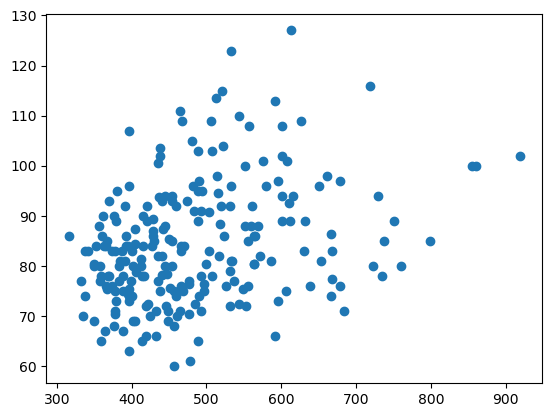

In [24]:
plt.scatter(data_num["TAP_I_8"], data_num["Waist_cm"])

In [25]:
plt.scatter(data_num["TAP_I_8"], data_num["TeiQueSF_total"])

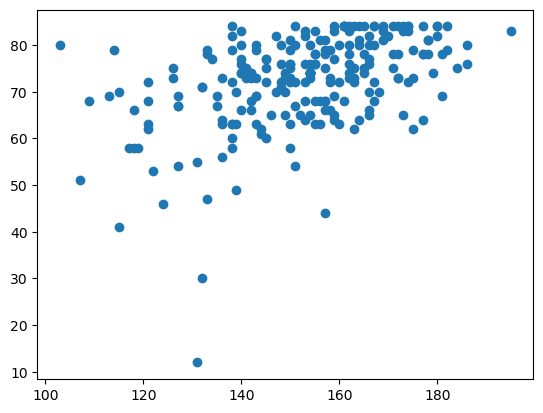

In [26]:
plt.scatter(data_num["TeiQueSF_total"], data_num["MSPSS_total"])

In [29]:
%cd {SCRIPTS_PATH}

/Users/artemii/obrain_lab/projects/obesity-types/grant-proposals/sigrid-juselius-2022/scripts


## Clustering PCA no BMI/waist cm

In [35]:
# This code was used for analysis demonstrated in the proposal
# Don't fit a new model, use the saved one
NEW_MODEL = False

In [25]:
from sklearn.mixture import BayesianGaussianMixture
n_components = 10

bgm_on_pca_nobmi = BayesianGaussianMixture(n_components=n_components,
                                           n_init=20,
                                           covariance_type="full",
                                           weight_concentration_prior=10000,
                                           init_params="k-means++",
                                           random_state=44)

In [36]:
if NEW_MODEL:
    bgm_on_pca_nobmi.fit(components_nobmi)
    cluster_list = list(zip(range(n_components), bgm_on_pca_nobmi.weights_))

In [ ]:
# Clusters and centroid coordinates
list(zip(cluster_list, bgm_on_pca_nobmi.means_))

In [ ]:
fig = plot_gaussian_mixture(bgm_on_pca_nobmi, components_nobmi)
# Clusters shown on plot are (clockwise): 0, 3, 8, 1 
fig

#### Dump models and save data

In [ ]:
%cd {SCRIPTS_PATH}

if SAVE_FILES:
    pkl.dump(bgm_on_pca_nobmi, open('processed_data/bgm_on_pca_nobmi.mdl', 'wb'))
    np.save('processed_data/components_nobmi.npy', components_nobmi)
    data_num.to_csv('processed_data/behavioural_numerical_data.csv')
    bgm_cluster_on_pca_nobmi = bgm_on_pca_nobmi.predict(components_nobmi)
    data_bgm_clustered_on_pca_nobmi = data_num.copy()
    data_bgm_clustered_on_pca_nobmi['bgm_pca_cluster'] = bgm_cluster_on_pca_nobmi
    data_bgm_clustered_on_pca_nobmi.to_csv("processed_data/clustered_behavioral_LEMON_pca_based_nobmi.csv")

# Plotting functions for behavioural clustering

## Import libraries and data

In [623]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import pandas as pd
import plotly.express as px
import sys
import pickle as pkl

In [624]:
%cd {SCRIPTS_PATH}

bgm_on_pca_nobmi = pkl.load(open('processed_data/bgm_on_pca_nobmi.mdl', 'rb'))
components_nobmi = np.load('processed_data/components_nobmi.npy')
data_num = pd.read_csv('processed_data/behavioural_numerical_data.csv')

/Users/artemii/obrain_lab/projects/obesity-types/grant-proposals/sigrid-juselius-2022/scripts


## Colour scheme

In [625]:
color_list_subtle = ['steelblue',
                     'wheat',
                     'coral']

color_list_detailed = ['darkblue',
                       'skyblue',
                       'darkorange',
                       'orangered']

color_list_very_detailed = ['darkblue',
                            'skyblue',
                            'olivedrab',
                            'gold',
                            'orangered']

cmap_subtle = colors.LinearSegmentedColormap.from_list('juselius22_subtle', color_list_subtle)
cmap_detailed = colors.LinearSegmentedColormap.from_list('juselius22_detailed', color_list_detailed)
cmap_very_detailed = colors.LinearSegmentedColormap.from_list('juselius22_very_detailed', color_list_very_detailed)

## Fonts

In [626]:
from matplotlib.font_manager import FontProperties, FontManager
# ?
# mgr = FontManager()
# mgr.get_font_names()

In [627]:
font = FontProperties()
font.set_name('Helvetica')

### Show default rcParams

In [23]:
if VERBOSE:
    plt.rcParams

## Plotting

### Scatter

In [22]:
if VERBOSE:
    print(plt.colormaps())

In [630]:
fig, ax = plt.subplots(figsize=[6, 7])

cmap = cmap_detailed

scatter = ax.scatter(components_nobmi[:,0], components_nobmi[:,1],
                     c=data_num['Waist_cm'], alpha=1, s=25, cmap=cmap,
                     #norm=colors.LogNorm(
                     #    vmin=data_num['Waist_cm'].min(), vmax=data_num['Waist_cm'].max()
                     #)
                    )

ax.grid(False)
ax.set_xlabel('Principal component 1', fontproperties=font, fontsize=18)
ax.set_ylabel('Principal component 2', fontproperties=font, fontsize=18)
ax.tick_params(labelsize=18)

colorbar = fig.colorbar(scatter, ticks=[],
                        location='bottom',
                        anchor=(0.98, 3.1),
                        shrink=0.2, aspect=5)

colorbar.set_label('Waist, cm', loc='center', size=12)

if SAVE_FILES:
    plt.savefig('plots/behavioural_pca_cmap_detailed.svg')
plt.show()

### Clustering

#### Plotting functions

In [631]:
# Tweaking the code from the book to adjust the style

from matplotlib.colors import LogNorm

one_legend = True


def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]

    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=60, linewidths=8,
                color=circle_color, zorder=10, alpha=0.5)
    x = 0
    y = 0
    centroids_text = centroids.copy() - 0.5
    for marker in [0, 1, 3, 8]:
        plt.text(centroids_text[x, 0], centroids_text[y, 1],
                 str(marker), fontsize=20,
                 color=cross_color,
                 zorder=11, alpha=1)
        x += 1
        y += 1
        
    if not one_legend:
        x = 0
        y = 0
        cluster_size_coordinates = np.array([[-10, -4.5],
                                             [9, -4.5],
                                             [-8, 10],
                                             [6, 10]])
        for cluster_size in [127, 34, 15, 52]:
            plt.text(cluster_size_coordinates[x, 0], cluster_size_coordinates[y, 1],
                     "N="+str(cluster_size), fontsize=15,
                     color=cross_color,
                     zorder=11, alpha=1)
            x += 1
            y += 1
    else:
        legend_coordinates = [12.5, -5]
        plt.text(legend_coordinates[0], legend_coordinates[1],
                 "0: N = 127\n1: N = 34\n3: N = 15\n8: N = 52", fontsize=11,
                 color=cross_color,
                 zorder=11, alpha=1)

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    #plt.contourf(xx, yy, Z,
    #             norm=LogNorm(vmin=1.0, vmax=30.0),
    #             levels=np.logspace(0, 2, 12))
    #plt.contour(xx, yy, Z,
    #            norm=LogNorm(vmin=1.0, vmax=30.0),
    #            levels=np.logspace(0, 2, 12),
    #            linewidths=1, colors='k')
    
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    fig, ax = plt.subplots(figsize=[6, 7])
    ax.contour(xx, yy, Z,
               linewidths=1, colors='black', linestyles='dashed')
    
    ax.scatter(X[:, 0], X[:, 1],
               c=data_num['Waist_cm'],
               alpha=1, s=25, cmap=cmap
              )
    plot_centroids(clusterer.means_, clusterer.weights_)
    
    ax.set_xlabel('Principal component 1', fontproperties=font, fontsize=18)
    if show_ylabels:
        ax.set_ylabel('Principal component 2', fontproperties=font, fontsize=18)
    else:
        ax.tick_params(labelleft=False)
    ax.tick_params(labelsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    colorbar = fig.colorbar(scatter, ticks=[],
                            location='bottom',
                            anchor=(0.97, 3.25),
                            shrink=0.2, aspect=5)
    colorbar.set_label('Waist, cm', loc='center', size=12)
    if SAVE_FILES:
        plt.savefig('plots/behavioural_clusters_cmap_detailed.svg')

#### Plot clustering

/var/folders/bf/gw7g3vwn4cl_k752qcmmxhdh0000gn/T/ipykernel_18678/707347950.py:84: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  colorbar = fig.colorbar(scatter, ticks=[],


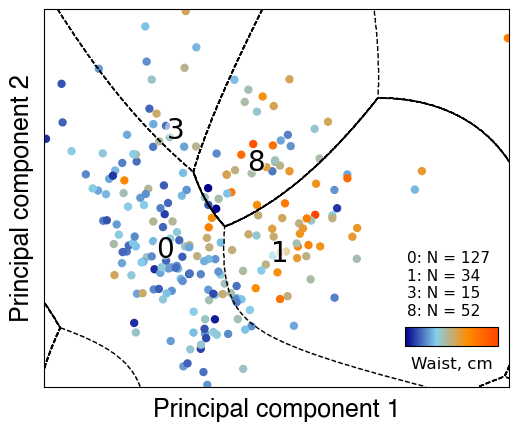

In [632]:
cmap = cmap_detailed
fig = plot_gaussian_mixture(bgm_on_pca_nobmi, components_nobmi)
# Clusters shown on plot are (clockwise): 0, 3, 8, 1
plt.show()


In [635]:
bgm_cluster_on_pca_nobmi = bgm_on_pca_nobmi.predict(components_nobmi)
data_bgm_clustered_on_pca_nobmi = data_num.copy()
data_bgm_clustered_on_pca_nobmi['bgm_pca_cluster'] = bgm_cluster_on_pca_nobmi
data_bgm_clustered_on_pca_nobmi.to_csv("processed_data/clustered_behavioral_LEMON_pca_based_nobmi.csv")

In [636]:
data_bgm_clustered_on_pca_nobmi.groupby('bgm_pca_cluster', as_index=False)['FEV_KK', 'FEV_STOER', 'FEV_HUNGER', 'BMI'].agg('mean')

/var/folders/bf/gw7g3vwn4cl_k752qcmmxhdh0000gn/T/ipykernel_18678/3214915997.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_bgm_clustered_on_pca_nobmi.groupby('bgm_pca_cluster', as_index=False)['FEV_KK', 'FEV_STOER', 'FEV_HUNGER', 'BMI'].agg('mean')


bgm_pca_cluster    FEV_KK  FEV_STOER  FEV_HUNGER        BMI
0                0  5.267717   5.338583    5.543307  23.108337
1                1  8.846154   4.153846    3.307692  26.232232
2                3  5.142857   5.500000    4.285714  23.455754
3                7  5.000000   5.000000    4.000000  28.801077
4                8  7.617647   3.735294    3.088235  25.557152

#### ANOVA analysis of BMI between clusters

In [637]:
BMI_clust_0 = np.array(data_bgm_clustered_on_pca_nobmi[data_bgm_clustered_on_pca_nobmi['bgm_pca_cluster'] == 0]['BMI'])
BMI_clust_1 = np.array(data_bgm_clustered_on_pca_nobmi[data_bgm_clustered_on_pca_nobmi['bgm_pca_cluster'] == 1]['BMI'])
BMI_clust_3 = np.array(data_bgm_clustered_on_pca_nobmi[data_bgm_clustered_on_pca_nobmi['bgm_pca_cluster'] == 3]['BMI'])
BMI_clust_8= np.array(data_bgm_clustered_on_pca_nobmi[data_bgm_clustered_on_pca_nobmi['bgm_pca_cluster'] == 8]['BMI'])

from scipy.stats import f_oneway
f_oneway(BMI_clust_0, BMI_clust_1,
         BMI_clust_3, BMI_clust_8)

F_onewayResult(statistic=12.767456676580391, pvalue=9.906761284154145e-08)

In [638]:
from scipy.stats import tukey_hsd
bmi_hsd = tukey_hsd(BMI_clust_0, BMI_clust_1,
                    BMI_clust_3, BMI_clust_8)
pd.DataFrame(bmi_hsd.pvalue, columns=[0, 1, 3, 8], index=[0, 1, 3, 8])

0             1         3         8
0  1.000000e+00  3.369872e-07  0.983274  0.001249
1  3.369872e-07  1.000000e+00  0.034137  0.801259
3  9.832739e-01  3.413731e-02  1.000000  0.206278
8  1.249491e-03  8.012595e-01  0.206278  1.000000